In [1]:
%%capture
!pip install super-gradients
!pip install --upgrade pillow
!pip install --upgrade torchvision

In [2]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

The console stream is logged into /root/sg_logs/console.log


[2023-11-30 23:29:07] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-30 23:29:08] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-30 23:29:08] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-30 23:29:20] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-30 23:29:20] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-30 23:29:20] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-30 23:29:20] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-30 23:29:20] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-30 23:29:20] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-30 23:29:20] WARNING - env_sanity_check.py - 

In [3]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'finding-battleships' #specify the experiment name
    #dataset params
    DATA_DIR = '/content/drive/MyDrive/archive' #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [4]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME,
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [5]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-11-30 23:30:03] WARNING - yolo_format_detection.py - 8 images are note associated to any label file
[2023-11-30 23:30:03] WARNING - yolo_format_detection.py - 10 label files are not associated to any image.
[2023-11-30 23:30:03] WARNING - yolo_format_detection.py - As a consequence, 5805/5813 images and 5805/5815 label files will be used.
[2023-11-30 23:30:03] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|█████████▉| 5804/5805 [28:00<00:00,  3.91it/s]

In [6]:
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-12-01 00:11:35] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|█████████▉| 547/549 [02:45<00:00,  3.39it/s]

In [7]:
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-12-01 00:22:27] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|█████████▉| 278/279 [01:18<00:00,  4.24it/s]

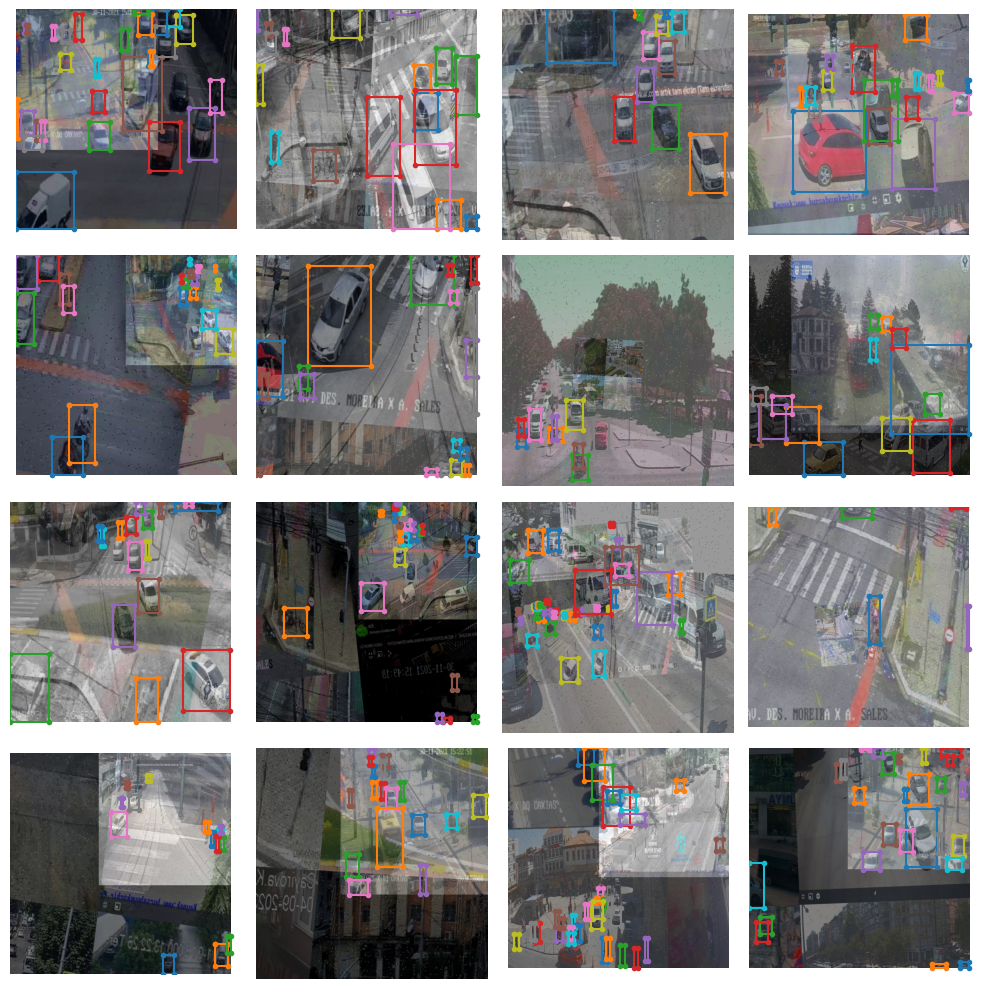

In [8]:
train_data.dataset.plot()

In [9]:
!pip install torchinfo
from torchinfo import summary

model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

model.eval()
summary(model, input_size=(1, 3, 640, 640))

[2023-12-01 00:24:07] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:03<00:00, 69.2MB/s]
[2023-12-01 00:24:11] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


Layer (type:depth-idx)                                       Output Shape              Param #
YoloNAS_L                                                    [1, 8400, 4]              --
├─NStageBackbone: 1-1                                        [1, 96, 160, 160]         --
│    └─YoloNASStem: 2-1                                      [1, 48, 320, 320]         --
│    │    └─QARepVGGBlock: 3-1                               [1, 48, 320, 320]         3,024
│    └─YoloNASStage: 2-2                                     [1, 96, 160, 160]         --
│    │    └─QARepVGGBlock: 3-2                               [1, 96, 160, 160]         88,128
│    │    └─YoloNASCSPLayer: 3-3                             [1, 96, 160, 160]         758,594
│    └─YoloNASStage: 2-3                                     [1, 192, 80, 80]          --
│    │    └─QARepVGGBlock: 3-4                               [1, 192, 80, 80]          351,360
│    │    └─YoloNASCSPLayer: 3-5                             [1, 192, 80, 80] 

In [10]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True, #mixed precision is not available for CPU
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [11]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-12-01 00:24:31] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231201_002431_003259`
[2023-12-01 00:24:31] INFO - sg_trainer.py - Checkpoints directory: checkpoints/finding-battleships/RUN_20231201_002431_003259
[2023-12-01 00:24:31] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/finding-battleships/RUN_20231201_002431_003259/console_Dec01_00_24_31.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2023-12-01 00:24:40] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8843
│   ├── Ppyoloeloss/loss_iou = 0.8039
│   ├── Ppyoloeloss/loss_dfl = 0.6547
│   └── Ppyoloeloss/loss = 3.3429
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5132
    ├── Ppyoloeloss/loss_iou = 0.5799
    ├── Ppyoloeloss/loss_dfl = 0.4663
    ├── Ppyoloeloss/loss = 2.5594
    ├── Precision@0.50 = 0.04
    ├── Recall@0.50 = 0.1399
    ├── Map@0.50 = 0.1044
    └── F1@0.50 = 0.047



Validating epoch 1: 100%|██████████| 33/33 [00:27<00:00,  1.18it/s]
[2023-12-01 00:45:40] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 00:45:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6802878975868225


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9149
│   │   ├── Epoch N-1      = 1.8843 (↘ -0.9694)
│   │   └── Best until now = 1.8843 (↘ -0.9694)
│   ├── Ppyoloeloss/loss_iou = 0.5652
│   │   ├── Epoch N-1      = 0.8039 (↘ -0.2387)
│   │   └── Best until now = 0.8039 (↘ -0.2387)
│   ├── Ppyoloeloss/loss_dfl = 0.4575
│   │   ├── Epoch N-1      = 0.6547 (↘ -0.1972)
│   │   └── Best until now = 0.6547 (↘ -0.1972)
│   └── Ppyoloeloss/loss = 1.9376
│       ├── Epoch N-1      = 3.3429 (↘ -1.4053)
│       └── Best until now = 3.3429 (↘ -1.4053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7617
    │   ├── Epoch N-1      = 1.5132 (↘ -0.7515)
    │   └── Best until now = 1.5132 (↘ -0.7515)
    ├── Ppyoloeloss/loss_iou = 0.4376
    │   ├── Epoch N-1      = 0.5799 (↘ -0.1423)
    │   └── Best until now = 0.5799 (↘ -0.1423)
    ├── Ppyoloeloss/loss_dfl = 0.3823
    │   ├── Epoch N-1      = 0.4663 (↘ -0.0841)
    │   └── Best until now = 0.4663 (↘ -0.0841)
    ├── Ppyoloeloss/lo

Validating epoch 2: 100%|██████████| 33/33 [00:26<00:00,  1.24it/s]
[2023-12-01 00:56:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 00:56:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7516850829124451


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.835
│   │   ├── Epoch N-1      = 0.9149 (↘ -0.08)
│   │   └── Best until now = 0.9149 (↘ -0.08)
│   ├── Ppyoloeloss/loss_iou = 0.5268
│   │   ├── Epoch N-1      = 0.5652 (↘ -0.0384)
│   │   └── Best until now = 0.5652 (↘ -0.0384)
│   ├── Ppyoloeloss/loss_dfl = 0.4384
│   │   ├── Epoch N-1      = 0.4575 (↘ -0.019)
│   │   └── Best until now = 0.4575 (↘ -0.019)
│   └── Ppyoloeloss/loss = 1.8002
│       ├── Epoch N-1      = 1.9376 (↘ -0.1374)
│       └── Best until now = 1.9376 (↘ -0.1374)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7428
    │   ├── Epoch N-1      = 0.7617 (↘ -0.0189)
    │   └── Best until now = 0.7617 (↘ -0.0189)
    ├── Ppyoloeloss/loss_iou = 0.4239
    │   ├── Epoch N-1      = 0.4376 (↘ -0.0137)
    │   └── Best until now = 0.4376 (↘ -0.0137)
    ├── Ppyoloeloss/loss_dfl = 0.378
    │   ├── Epoch N-1      = 0.3823 (↘ -0.0043)
    │   └── Best until now = 0.3823 (↘ -0.0043)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 3: 100%|██████████| 33/33 [00:26<00:00,  1.22it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8175
│   │   ├── Epoch N-1      = 0.835  (↘ -0.0175)
│   │   └── Best until now = 0.835  (↘ -0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.5197
│   │   ├── Epoch N-1      = 0.5268 (↘ -0.0071)
│   │   └── Best until now = 0.5268 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.4342
│   │   ├── Epoch N-1      = 0.4384 (↘ -0.0043)
│   │   └── Best until now = 0.4384 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.7714
│       ├── Epoch N-1      = 1.8002 (↘ -0.0289)
│       └── Best until now = 1.8002 (↘ -0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7403
    │   ├── Epoch N-1      = 0.7428 (↘ -0.0025)
    │   └── Best until now = 0.7428 (↘ -0.0025)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4239 (↘ -0.0083)
    │   └── Best until now = 0.4239 (↘ -0.0083)
    ├── Ppyoloeloss/loss_dfl = 0.3777
    │   ├── Epoch N-1      = 0.378  (↘ -0.0002)
    │   └── Best until now = 0.378  (↘ -0.0002)
    ├── Ppyoloeloss/lo

Validating epoch 4: 100%|██████████| 33/33 [00:27<00:00,  1.21it/s]
[2023-12-01 01:16:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 01:16:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7843128442764282


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7923
│   │   ├── Epoch N-1      = 0.8175 (↘ -0.0252)
│   │   └── Best until now = 0.8175 (↘ -0.0252)
│   ├── Ppyoloeloss/loss_iou = 0.5012
│   │   ├── Epoch N-1      = 0.5197 (↘ -0.0185)
│   │   └── Best until now = 0.5197 (↘ -0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.4235
│   │   ├── Epoch N-1      = 0.4342 (↘ -0.0107)
│   │   └── Best until now = 0.4342 (↘ -0.0107)
│   └── Ppyoloeloss/loss = 1.717
│       ├── Epoch N-1      = 1.7714 (↘ -0.0544)
│       └── Best until now = 1.7714 (↘ -0.0544)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7093
    │   ├── Epoch N-1      = 0.7403 (↘ -0.031)
    │   └── Best until now = 0.7403 (↘ -0.031)
    ├── Ppyoloeloss/loss_iou = 0.3989
    │   ├── Epoch N-1      = 0.4156 (↘ -0.0167)
    │   └── Best until now = 0.4156 (↘ -0.0167)
    ├── Ppyoloeloss/loss_dfl = 0.3724
    │   ├── Epoch N-1      = 0.3777 (↘ -0.0054)
    │   └── Best until now = 0.3777 (↘ -0.0054)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 33/33 [00:26<00:00,  1.23it/s]
[2023-12-01 01:27:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 01:27:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7892581820487976


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7769
│   │   ├── Epoch N-1      = 0.7923 (↘ -0.0154)
│   │   └── Best until now = 0.7923 (↘ -0.0154)
│   ├── Ppyoloeloss/loss_iou = 0.4882
│   │   ├── Epoch N-1      = 0.5012 (↘ -0.013)
│   │   └── Best until now = 0.5012 (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.416
│   │   ├── Epoch N-1      = 0.4235 (↘ -0.0075)
│   │   └── Best until now = 0.4235 (↘ -0.0075)
│   └── Ppyoloeloss/loss = 1.6811
│       ├── Epoch N-1      = 1.717  (↘ -0.0359)
│       └── Best until now = 1.717  (↘ -0.0359)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7129
    │   ├── Epoch N-1      = 0.7093 (↗ 0.0036)
    │   └── Best until now = 0.7093 (↗ 0.0036)
    ├── Ppyoloeloss/loss_iou = 0.3996
    │   ├── Epoch N-1      = 0.3989 (↗ 0.0008)
    │   └── Best until now = 0.3989 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.3705
    │   ├── Epoch N-1      = 0.3724 (↘ -0.0018)
    │   └── Best until now = 0.3724 (↘ -0.0018)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 6: 100%|██████████| 33/33 [00:26<00:00,  1.23it/s]
[2023-12-01 01:38:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 01:38:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8170299530029297


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7562
│   │   ├── Epoch N-1      = 0.7769 (↘ -0.0207)
│   │   └── Best until now = 0.7769 (↘ -0.0207)
│   ├── Ppyoloeloss/loss_iou = 0.4727
│   │   ├── Epoch N-1      = 0.4882 (↘ -0.0155)
│   │   └── Best until now = 0.4882 (↘ -0.0155)
│   ├── Ppyoloeloss/loss_dfl = 0.4077
│   │   ├── Epoch N-1      = 0.416  (↘ -0.0083)
│   │   └── Best until now = 0.416  (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.6366
│       ├── Epoch N-1      = 1.6811 (↘ -0.0445)
│       └── Best until now = 1.6811 (↘ -0.0445)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6876
    │   ├── Epoch N-1      = 0.7129 (↘ -0.0252)
    │   └── Best until now = 0.7093 (↘ -0.0216)
    ├── Ppyoloeloss/loss_iou = 0.3973
    │   ├── Epoch N-1      = 0.3996 (↘ -0.0024)
    │   └── Best until now = 0.3989 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.3669
    │   ├── Epoch N-1      = 0.3705 (↘ -0.0036)
    │   └── Best until now = 0.3705 (↘ -0.0036)
    ├── Ppyoloeloss/lo

Validating epoch 7: 100%|██████████| 33/33 [00:26<00:00,  1.24it/s]
[2023-12-01 01:50:12] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 01:50:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8390898704528809


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7417
│   │   ├── Epoch N-1      = 0.7562 (↘ -0.0146)
│   │   └── Best until now = 0.7562 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.4593
│   │   ├── Epoch N-1      = 0.4727 (↘ -0.0134)
│   │   └── Best until now = 0.4727 (↘ -0.0134)
│   ├── Ppyoloeloss/loss_dfl = 0.4003
│   │   ├── Epoch N-1      = 0.4077 (↘ -0.0074)
│   │   └── Best until now = 0.4077 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 1.6013
│       ├── Epoch N-1      = 1.6366 (↘ -0.0353)
│       └── Best until now = 1.6366 (↘ -0.0353)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6681
    │   ├── Epoch N-1      = 0.6876 (↘ -0.0195)
    │   └── Best until now = 0.6876 (↘ -0.0195)
    ├── Ppyoloeloss/loss_iou = 0.3851
    │   ├── Epoch N-1      = 0.3973 (↘ -0.0122)
    │   └── Best until now = 0.3973 (↘ -0.0122)
    ├── Ppyoloeloss/loss_dfl = 0.3642
    │   ├── Epoch N-1      = 0.3669 (↘ -0.0027)
    │   └── Best until now = 0.3669 (↘ -0.0027)
    ├── Ppyoloeloss/lo

Validating epoch 8: 100%|██████████| 33/33 [00:26<00:00,  1.23it/s]
[2023-12-01 02:01:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 02:01:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8457838296890259


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7203
│   │   ├── Epoch N-1      = 0.7417 (↘ -0.0214)
│   │   └── Best until now = 0.7417 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_iou = 0.4454
│   │   ├── Epoch N-1      = 0.4593 (↘ -0.0139)
│   │   └── Best until now = 0.4593 (↘ -0.0139)
│   ├── Ppyoloeloss/loss_dfl = 0.3936
│   │   ├── Epoch N-1      = 0.4003 (↘ -0.0068)
│   │   └── Best until now = 0.4003 (↘ -0.0068)
│   └── Ppyoloeloss/loss = 1.5593
│       ├── Epoch N-1      = 1.6013 (↘ -0.042)
│       └── Best until now = 1.6013 (↘ -0.042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6622
    │   ├── Epoch N-1      = 0.6681 (↘ -0.0059)
    │   └── Best until now = 0.6681 (↘ -0.0059)
    ├── Ppyoloeloss/loss_iou = 0.3828
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0023)
    │   └── Best until now = 0.3851 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.3598
    │   ├── Epoch N-1      = 0.3642 (↘ -0.0044)
    │   └── Best until now = 0.3642 (↘ -0.0044)
    ├── Ppyoloeloss/loss

Validating epoch 9: 100%|██████████| 33/33 [00:26<00:00,  1.24it/s]
[2023-12-01 02:13:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/RUN_20231201_002431_003259/ckpt_best.pth
[2023-12-01 02:13:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.858045220375061


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7096
│   │   ├── Epoch N-1      = 0.7203 (↘ -0.0106)
│   │   └── Best until now = 0.7203 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_iou = 0.4371
│   │   ├── Epoch N-1      = 0.4454 (↘ -0.0083)
│   │   └── Best until now = 0.4454 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.3873
│   │   ├── Epoch N-1      = 0.3936 (↘ -0.0063)
│   │   └── Best until now = 0.3936 (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.5341
│       ├── Epoch N-1      = 1.5593 (↘ -0.0252)
│       └── Best until now = 1.5593 (↘ -0.0252)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6522
    │   ├── Epoch N-1      = 0.6622 (↘ -0.01)
    │   └── Best until now = 0.6622 (↘ -0.01)
    ├── Ppyoloeloss/loss_iou = 0.3699
    │   ├── Epoch N-1      = 0.3828 (↘ -0.0129)
    │   └── Best until now = 0.3828 (↘ -0.0129)
    ├── Ppyoloeloss/loss_dfl = 0.3545
    │   ├── Epoch N-1      = 0.3598 (↘ -0.0053)
    │   └── Best until now = 0.3598 (↘ -0.0053)
    ├── Ppyoloeloss/loss =

[2023-12-01 02:14:50] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 33/33 [00:27<00:00,  1.28it/s]

In [13]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join('/content/checkpoints/finding-battleships/RUN_20231201_002431_003259', 'average_model.pth'))

In [14]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
               top_k_predictions=300,
               num_cls=config.NUM_CLASSES,
               normalize_targets=True,
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01,
                  nms_top_k=1000,
                  max_predictions=300,
                  nms_threshold=0.7)
               ))

Testing: 100%|██████████| 16/16 [00:18<00:00,  1.02s/it]

{'PPYoloELoss/loss_cls': 0.6588042,
 'PPYoloELoss/loss_iou': 0.37453103,
 'PPYoloELoss/loss_dfl': 0.3563862,
 'PPYoloELoss/loss': 1.3897214,
 'Precision@0.50': 0.09793821722269058,
 'Recall@0.50': 0.967637836933136,
 'mAP@0.50': 0.8642565608024597,
 'F1@0.50': 0.1755351722240448}

Testing: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]
